機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。



【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。

keras/lstm_seq2seq.py at master · keras-team/keras

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）
51から55行目 : ライブラリのimport
57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》

この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。

scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。

charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
from __future__ import print_function

from  keras.models import Model
from keras.layers import Input , LSTM , Dense
from keras.callbacks import EarlyStopping

In [6]:
! http://www.manythings.org/anki/fra-eng.zip

/bin/sh: http://www.manythings.org/anki/fra-eng.zip: No such file or directory


In [4]:
! http://www.manythings.org/anki/

/bin/sh: http://www.manythings.org/anki/: No such file or directory


In [7]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [21]:
# ハイパーパラメーター
batch_size = 64
epochs = 10
latent_dim = 256
num_samples = 10000
data_path = "fra.txt"

# データのベクトル化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

#データファイルの読み込み
with open(data_path , "r" , encoding="utf-8") as f:
  lines = f.read().split("\n") #改行で文字列を分割している
#データの前処理
for line in lines[: min(num_samples , len(lines) - 1)]:
  input_text , target_text , _ = line.split("\t")
  target_text = "\t" + target_text + "\n"
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)
    
input_characters = sorted(list(input_characters)) #文字を順番に並べる
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) #文字の数
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])#txtの中の最大数の文字
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [22]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_dataはdecoder_input_dataより1タイムステップだけ進んでいます
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decode_target_dataは1タイムステップ先になります
            # 開始文字は含まれません。
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# 入力シーケンスを定義して処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 「encoder_outputs」を破棄し、状態のみを保持します。
encoder_states = [state_h, state_c]

In [23]:
# 初期状態として「encoder_states」を使用して、デコーダーをセットアップします。
decoder_inputs = Input(shape=(None, num_decoder_tokens))
#完全な出力シーケンスを返すようにデコーダを設定し、
#また、内部状態も返します。
#トレーニングモデルでは戻り状態を使用しませんが、推論では使用します。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#回転するモデルを定義する
#「encoder_input_data」と「decoder_input_data」を「decoder_target_data」に
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
early_stopping = EarlyStopping(monitor="val_loss", patience=10) 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[early_stopping])
# Save model
model.save('s2s.h5')

#次：推論モード（サンプリング）。
#ドリルは次のとおりです。
#1）入力をエンコードし、初期デコーダー状態を取得する
#2）この初期状態でデコーダーの1ステップを実行する
#およびターゲットとしての「シーケンスの開始」トークン。
#出力は次のターゲットトークンになります
#3）現在のターゲットトークンと現在の状態で繰り返します

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 52s 7ms/step - loss: 1.1898 - accuracy: 0.7239 - val_loss: 1.1212 - val_accuracy: 0.6998
Epoch 2/10
8000/8000 [==============================] - 49s 6ms/step - loss: 0.8607 - accuracy: 0.7671 - val_loss: 0.8367 - val_accuracy: 0.7681
Epoch 3/10
8000/8000 [==============================] - 53s 7ms/step - loss: 0.6780 - accuracy: 0.8084 - val_loss: 0.7269 - val_accuracy: 0.7909
Epoch 4/10
8000/8000 [==============================] - 53s 7ms/step - loss: 0.5929 - accuracy: 0.8280 - val_loss: 0.6784 - val_accuracy: 0.8008
Epoch 5/10
8000/8000 [==============================] - 50s 6ms/step - loss: 0.5448 - accuracy: 0.8408 - val_loss: 0.6051 - val_accuracy: 0.8222
Epoch 6/10
8000/8000 [==============================] - 47s 6ms/step - loss: 0.5079 - accuracy: 0.8512 - val_loss: 0.5784 - val_accuracy: 0.8312
Epoch 7/10
8000/8000 [==============================] - 48s 6ms/step - loss: 0.479

【問題2】イメージキャプショニングの学習済みモデルの実行

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [13]:
!pip uninstall torch

In [16]:
!pip install torchvision==0.2.1

     |████████████████████████████████| 54 kB 385 kB/s eta 0:00:01
     |████████████████████████████████| 81.1 MB 37 kB/s eta 0:00:0115   |███▎                            | 8.4 MB 1.5 MB/s eta 0:00:49     |███████▏                        | 18.2 MB 5.6 MB/s eta 0:00:12     |███████▌                        | 19.0 MB 677 kB/s eta 0:01:32     |████████                        | 20.3 MB 677 kB/s eta 0:01:30     |████████                        | 20.5 MB 677 kB/s eta 0:01:30     |████████▌                       | 21.5 MB 677 kB/s eta 0:01:29     |████████▋                       | 21.9 MB 12.8 MB/s eta 0:00:05     |█████████                       | 22.9 MB 12.8 MB/s eta 0:00:05     |█████████▍                      | 23.9 MB 12.8 MB/s eta 0:00:05     |█████████▌                      | 24.2 MB 12.8 MB/s eta 0:00:05     |██████████▌                     | 26.6 MB 2.3 MB/s eta 0:00:24     |██████████▉                     | 27.4 MB 2.3 MB/s eta 0:00:24     |████████████                    | 30.5 MB

In [18]:
!pip install torch==0.4.1

     |████████████████████████████████| 11.5 MB 442 kB/s eta 0:00:01    |███████████████▊                | 5.7 MB 366 kB/s eta 0:00:16     |██████████████████████████████  | 10.8 MB 569 kB/s eta 0:00:02
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [19]:
#pytorchのバージョンを0.4.1へ　https://pytorch.org/get-started/previous-versions/
#torchvisionをインストール　conda install pytorch torchvision
import torch
print(torch.__version__)

0.4.1


In [1]:
%ls

20200123_EDA_example.ipynb
Breast.ipynb
CNN.ipynb
CNN2.ipynb
Classifier Flow(Home Credit)_2.ipynb
Comprehensive data exploration with Python | Kaggle.pdf
DICスライド/
DeepNN.ipynb
GAN.ipynb
Home Credit Default Risk Extensive EDA | Kaggle.webloc
HomeCredit_columns_description.csv*
Install.ipynb
Iris.csv
Keras.ipynb
MNIST.ipynb
Mr.Shibata_sprint2.ipynb
NN.ipynb
Pandas Graph.ipynb
Python for DATA ANALYSIS.ipynb
README.md
SVM.ipynb
SVM基本.ipynb
Scratch1_HomeCredit.ipynb
Sprint0_scratch.ipynb
Sprint10_CNN.ipynb
Sprint11_CNN2.ipynb
Sprint12_tensorflow.ipynb
Sprint13_Keras.ipynb
Sprint13_Tensorflow入門 (1).ipynb
Sprint14_Reading.ipynb
Sprint16_colab版の準備（受講生用） (1).ipynb
Sprint17_make_dataset（受講生用） (1).ipynb
Sprint18 segmentation.ipynb
Sprint18_colab版の準備（受講生用）_ipynb_のコピー.ipynb
Sprint18_セグメンテーション1.pdf
Sprint19/
Sprint19.ipynb
Sprint1_ML_Flow.ipynb
Sprint21.ipynb
Sprint22 RNN.ipynb
Sprint22_gateRNN.ipynb
Sprint23_seq2seq.ipynb
Sprint2_linear_regression.ipynb
Sprint3_logistic_regression.ipynb
Sprint4_De

In [4]:
%pwd
%cd ../

/Users/apple


In [5]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/Users/apple/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [7]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


In [8]:
from IPython.display import Image


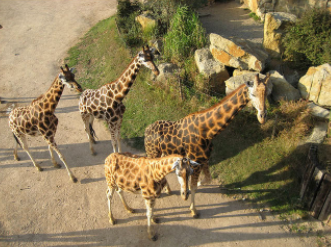

In [9]:
Image("./png/example.png")

In [10]:
!python sample.py --image='png/IMG_0310.JPG'

<start> a man is sitting on a bench next to a fence . <end>


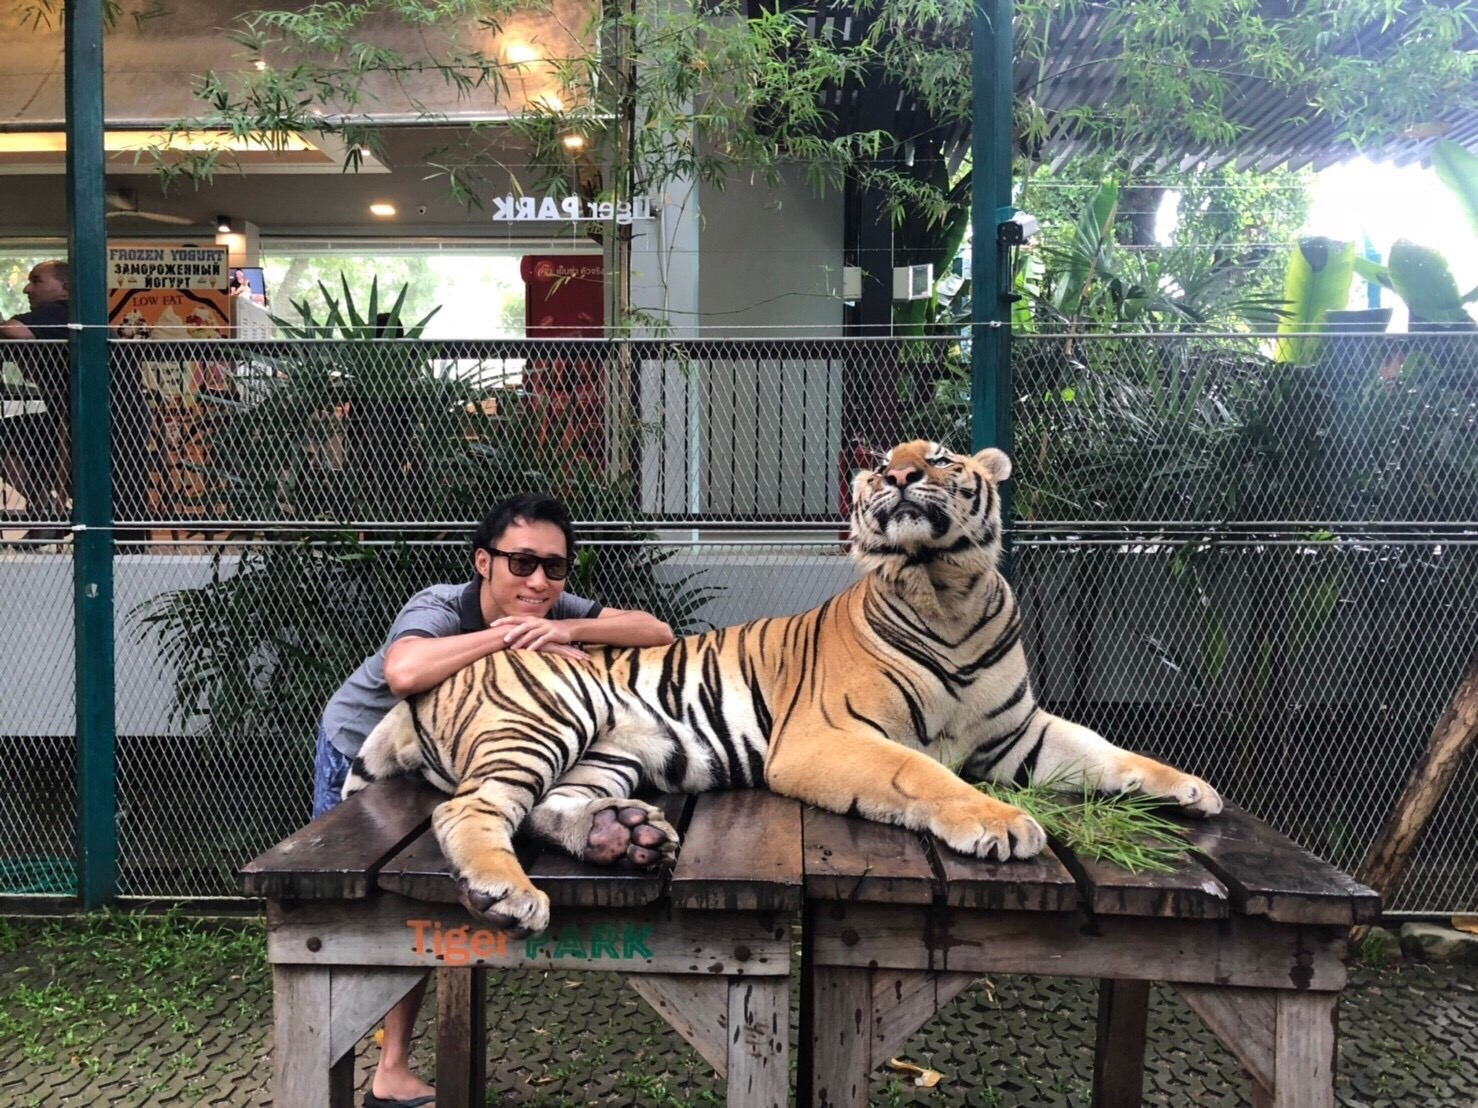

In [11]:
Image("./png/IMG_0310.JPG")

In [12]:
!python sample.py --image='png/31694_main.jpg'

<start> a zebra that is standing in the grass . <end>


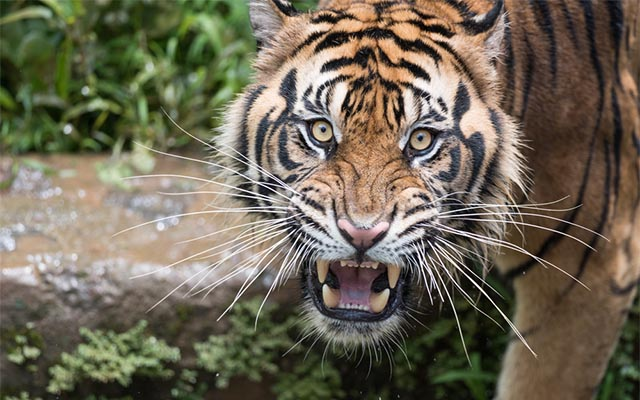

In [13]:
Image("./png/31694_main.jpg")

In [14]:
!python sample.py --image='png/IMG_1066.JPG'

<start> a large white bird standing on a rock . <end>


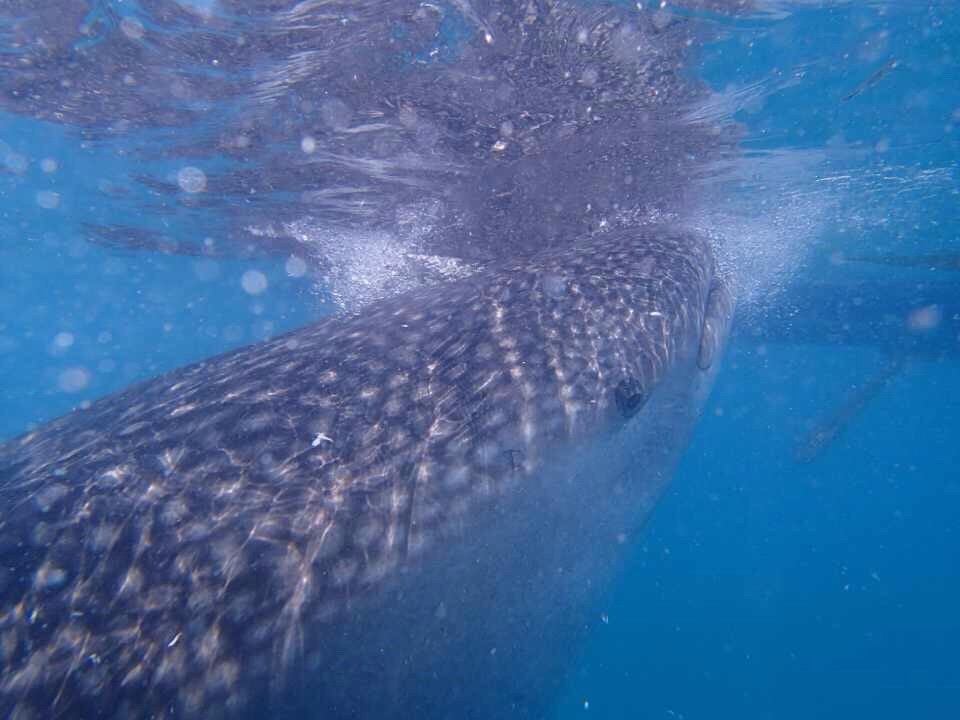

In [15]:
Image("./png/IMG_1066.JPG")

In [ ]:
!python sample.py --image='png/IMG_1066.JPG'

【問題3】Kerasで動かしたい場合はどうするかを調査  
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

https://qiita.com/koppe/items/7f85f5411539390c4499

MMdnnによって変換できる。